# Match Trigger and Event Catalog

## Import Libraries

In [1]:
import os, sys
import obspy as obs
import matplotlib.pyplot as plt

from obspy.clients.fdsn import Client
from obspy.signal.trigger import coincidence_trigger
from obspy import UTCDateTime
from numpy import sort, argmin, array
from pandas import DataFrame, value_counts, merge, read_pickle

from functions.add_distances_and_backazimuth import __add_distances_and_backazimuth
from functions.catalog_to_dataframe import __catalog_to_dataframe

In [2]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'

## Configurations

In [3]:
config = {}

## old
# config['time_period'] = "20221001_20230615"

## new
config['time_period'] = "20221001_20230930"

config['BSPF_lon'] = array([-116.455439])
config['BSPF_lat'] = array([33.610643])

config['path_to_catalogs'] = data_path+"BSPF/data/catalogs/"

config['catalog_filename'] = f"BSPF_catalog_{config['time_period']}_all.xml"

config['output_filename'] = f"BSPF_catalog_{config['time_period']}_triggered.xml"

config['client'] = Client("IRIS")

In [4]:
!ls /import/kilauea-data/BSPF/data/catalogs/

BSPF_catalog_20221001_20230930_all.pkl
BSPF_catalog_20221001_20230930_all.xml
BSPF_catalog_20221001_20230930_triggered.pkl
BSPF_catalog_20221001_20230930_triggered.xml
gcmt_solutions_20221001_20230930.xml
gmt_usgs_m3_m4.xml
OLD
tmp
triggered_2022-10-01_2023-09-30.log
triggered_2022-10-01_2023-09-30.pkl


## Load Catalog

In [5]:
## read catalog
cat = obs.read_events(config['path_to_catalogs']+config['catalog_filename'])
cat.events.sort(key=lambda event: event.origins[0].time)

## Load Triggered Events

In [6]:
def __read_pickle(config, path, filename):

    import pickle

    with open(path+filename, 'rb') as f:
        triggerfile = pickle.load(f)

    return triggerfile

In [7]:
trigger_events = __read_pickle(config, config['path_to_catalogs'], "triggered_2022-10-01_2023-09-30.pkl")

## Define reference time and separate for coincidence values

In [8]:
times, cosum, times_rel = [], [], []
ref_time = obs.UTCDateTime("2022-10-01")

for trig in trigger_events:
    times.append(trig['time'])
    cosum.append(trig['coincidence_sum'])
    times_rel.append((trig['time']-ref_time)/86400)

trigger_times = sort(times)

coinc4 = [ev for ev in trigger_events if ev['coincidence_sum'] == 4]
coinc5 = [ev for ev in trigger_events if ev['coincidence_sum'] == 5]
coinc6 = [ev for ev in trigger_events if ev['coincidence_sum'] == 6]

## Create dataframe & remove duplicates

In [9]:
df_trig = DataFrame()
df_trig['coincidence_sum'] = cosum
df_trig['trig_times_relative'] = times_rel
df_trig['trigger_time'] = trigger_times
df_trig['trigger_time'] = df_trig['trigger_time'].astype(str)

## remove duplicates of trigger time
df_trig = df_trig.drop_duplicates(["trigger_time"], keep="first").reset_index()

## remove trigger times before reference time
df_trig = df_trig[df_trig.trig_times_relative > 0]

trigger_times_unique = df_trig.trigger_time

print(f" removing duplicates")
print(f" before:  {len(trigger_times)}")
print(f" after:   {len(df_trig.trigger_time)}")

 removing duplicates
 before:  2518
 after:   1295


In [10]:
coinc0 = df_trig[df_trig.coincidence_sum >= 0]
coinc4 = df_trig[df_trig.coincidence_sum == 4]
coinc5 = df_trig[df_trig.coincidence_sum == 5]
coinc6 = df_trig[df_trig.coincidence_sum == 6]

In [11]:
print(f" total events:      {len(cat)}")
print(f" triggered events:  {len(trigger_events)}")

print(f" CoInc. = 4:        {len(coinc4)} ({round(len(coinc4)/len(coinc0)*100,1)} %)")
print(f" CoInc. = 5:        {len(coinc5)} ({round(len(coinc5)/len(coinc0)*100,1)} %)")
print(f" CoInc. = 6:        {len(coinc6)} ({round(len(coinc6)/len(coinc0)*100,1)} %)")

 total events:      10820
 triggered events:  2518
 CoInc. = 4:        216 (16.7 %)
 CoInc. = 5:        118 (9.1 %)
 CoInc. = 6:        961 (74.2 %)


## Match events of triggered catalog with event catalog

In [12]:
def __expected_arrival_times(catalog, sta_lat, sta_lon):

    from obspy.geodetics import locations2degrees
    from obspy.taup import TauPyModel

    model = TauPyModel(model="ak135") ## "ak135"

    expected_times, expected_paths = [], []
    for jj, ev in enumerate(catalog):
        if jj == 300:
            break

        ev_lat = ev.origins[0].latitude
        ev_lon = ev.origins[0].longitude
        ev_dep = ev.origins[0].depth / 1000
        ev_time = ev.origins[0].time

        dist_deg = locations2degrees(sta_lat, sta_lon, ev_lat, ev_lon)

        try:
            arrivals = model.get_travel_times(source_depth_in_km=ev_dep,
                                              distance_in_degree=dist_deg,
                                              phase_list=["P","S","pP","sS"]
                                             )
            print(arrivals)
            expected_times.append(ev_time + arrivals[0].time)
        except:
            print(f" -> failed to compute arrival times")

        try:
            paths = model.get_ray_paths(source_depth_in_km=ev_dep,
                                        distance_in_degree=dist_deg,
                                        phase_list=["P","S","pP","sS"]
                                        )
            expected_paths.append(paths)

        except:
            print(f" -> failed to compute arrival paths")

    return expected_times, expected_paths

In [13]:
# expected_times, expected_paths = __expected_arrival_times(cat[:20], config['BSPF_lat'], config['BSPF_lon'])
# expected_times, expected_paths

# for path in expected_paths:
#     try:
#         ax = path.plot_rays(plot_type="cartesian")
#     except:
#         print("no")

### Match triggers with event catalog based on travel time estimates

In [14]:
def __find_matches(catalog, sta_lat, sta_lon, trig_times, max_time_offset):

    from obspy.geodetics import locations2degrees
    from obspy.taup import TauPyModel
    from obspy import UTCDateTime, Catalog
    from tqdm.notebook import tqdm

    ## model for arrival times
    model = TauPyModel(model="ak135") ## "ak135", "iasp91", "prem"

    ## counter for failed arrival computations
    fails = 0

    ## output dataframe
    df_out = DataFrame(columns=["id", "event_time", "arrival_time", "trigger_time"])

    ## output catalog
    cat_out = Catalog()

    for jj, ev in enumerate(tqdm(catalog)):

        # if jj == 1000:
        #     break

        ## extract event data
        ev_lat = ev.origins[0].latitude
        ev_lon = ev.origins[0].longitude
        ev_dep = ev.origins[0].depth / 1000
        ev_time = ev.origins[0].time

        ## compute distance between station to event in degrees
        dist_deg = locations2degrees(sta_lat, sta_lon, ev_lat, ev_lon)


#         print(dist_deg[0], ev_dep)

        try:
            arrivals = model.get_travel_times(source_depth_in_km=ev_dep,
                                              distance_in_degree=dist_deg[0],
                                              phase_list=["P","S","pP","sS","sP","pS"]
                                             )

            expected_time = ev_time + arrivals[0].timeNone

        except Exception as e:
            fails += 1
            expected_time = ev_time
            # continue

        for nn, trig in enumerate(trig_times):

            ## compute absolute temporal distance
            abs_diff = abs(expected_time - UTCDateTime(trig))

            # diff = expected_time - UTCDateTime(trig)

            ## if distance below threshold, trigger is considered match with catalog event
            if abs_diff < max_time_offset:
                df_out.loc[len(df_out)] = [jj, ev_time, expected_time, trig]
                cat_out += ev
            else:
                continue


    print(f" -> failed for {fails} of {len(catalog)} to compute arrival times..:")

    return df_out, cat_out

In [15]:
df_out, cat_select = __find_matches(cat, config['BSPF_lat'], config['BSPF_lon'], trigger_times_unique, max_time_offset=10)

  0%|          | 0/10820 [00:00<?, ?it/s]

 -> failed for 10820 of 10820 to compute arrival times..:


In [54]:
df_all = merge(df_trig, df_out, on=['trigger_time'])
df_all

,index,coincidence_sum,trig_times_relative,trigger_time,id,event_time,arrival_time
0,7,4.0,0.510553,2022-10-01T05:36:10.344538Z,3,2022-10-01T05:36:11.240000Z,2022-10-01T05:36:11.240000Z
1,8,5.0,0.511175,2022-10-01T05:36:10.344539Z,3,2022-10-01T05:36:11.240000Z,2022-10-01T05:36:11.240000Z
2,38,6.0,0.867477,2022-10-01T21:26:51.694538Z,21,2022-10-01T21:26:43.530000Z,2022-10-01T21:26:43.530000Z
3,39,5.0,0.893654,2022-10-01T21:26:51.694539Z,21,2022-10-01T21:26:43.530000Z,2022-10-01T21:26:43.530000Z
4,49,6.0,1.142584,2022-10-02T03:25:19.269538Z,32,2022-10-02T03:25:16.440000Z,2022-10-02T03:25:16.440000Z
...,...,...,...,...,...,...,...
376,2460,6.0,353.024477,2023-09-19T16:59:28.415000Z,10563,2023-09-19T16:59:23.750000Z,2023-09-19T16:59:23.750000Z
377,2462,4.0,353.413024,2023-09-19T18:17:27.765000Z,10568,2023-09-19T18:17:24.190000Z,2023-09-19T18:17:24.190000Z
378,2474,6.0,354.998727,2023-09-21T01:58:25.900000Z,10598,2023-09-21T01:58:24.210000Z,2023-09-21T01:58:24.210000Z
379,2500,6.0,360.998727,2023-09-27T13:41:10.990000Z,10762,2023-09-27T13:41:07.510000Z,2023-09-27T13:41:07.510000Z


## Reject manually selected events of false positive triggers

In [55]:
## list of events to reject (manually)
no_event = ["2022-10-05 15:39:13.690",
            "2022-10-05 15:42:03.610",
            "2022-10-05 18:35:16.860",
            "2022-10-10 05:48:52.890",
            "2022-10-12 19:12:14.670",
            "2022-10-12 23:08:11.410",
            "2022-10-12 23:58:00.800",
            "2022-10-14 03:13:56.380",
            "2022-10-16 08:42:24.970",
            "2022-10-26 08:27:09.860",
            "2022-10-28 12:47:26.910",
            "2022-11-03 05:53:34.230",
            "2022-11-09 00:46:57.550",
            "2022-11-10 16:53:29.940",
            "2022-11-25 10:45:36.390",
            "2022-12-06 21:56:31.330",
            "2022-12-09 06:03:03.220",
            "2022-12-15 13:55:13.460",
            "2022-12-17 18:02:34.910",
            "2022-12-19 15:41:22.380",
            "2022-12-19 15:41:26.020",
            "2023-01-05 09:59:04.210",
            "2023-01-07 12:32:45.250",
            "2023-01-16 00:00:36.100",
            "2023-01-29 23:50:47.770",
            "2023-02-05 23:38:46.670",
            "2023-02-22 05:09:39.970",
            "2023-03-09 11:49:06.640",
            "2023-03-17 07:12:56.970",
            "2023-03-24 13:59:00.160",
            "2023-03-29 19:23:29.470",
            "2023-03-29 19:23:27.460",
            "2023-04-30 07:26:56.390",
            "2023-04-06 02:42:00.600",
            "2023-04-13 23:57:53.950",
            "2023-04-17 15:27:56.450",
            "2023-05-01 02:52:56.160",
            "2023-06-02 20:19:46.740",
            "2023-06-05 07:39:16.650",
           ]

## Remove manually selected events from catalog and create new catalog

In [56]:
no_event_utc = list(map(UTCDateTime, no_event))

n_before = len(df_all)

## remove defined events from data frame
df_all = df_all[df_all['event_time'].apply(lambda x: x not in no_event_utc)].reset_index()

## remove defined events from catalog
new_cat = obs.Catalog()
for tmp_ev in cat_select:
    if tmp_ev.origins[0].time not in no_event_utc:
        new_cat += tmp_ev

cat_select = new_cat


print(f" before:  {n_before} \n after:   {len(df_all)} \n manuall list: {len(no_event_utc)}  \n rejected: {n_before-len(df_all)}")

 before:  381 
 after:   350 
 manuall list: 39  
 rejected: 31


array([<Axes: title={'center': 'dates'}>], dtype=object)

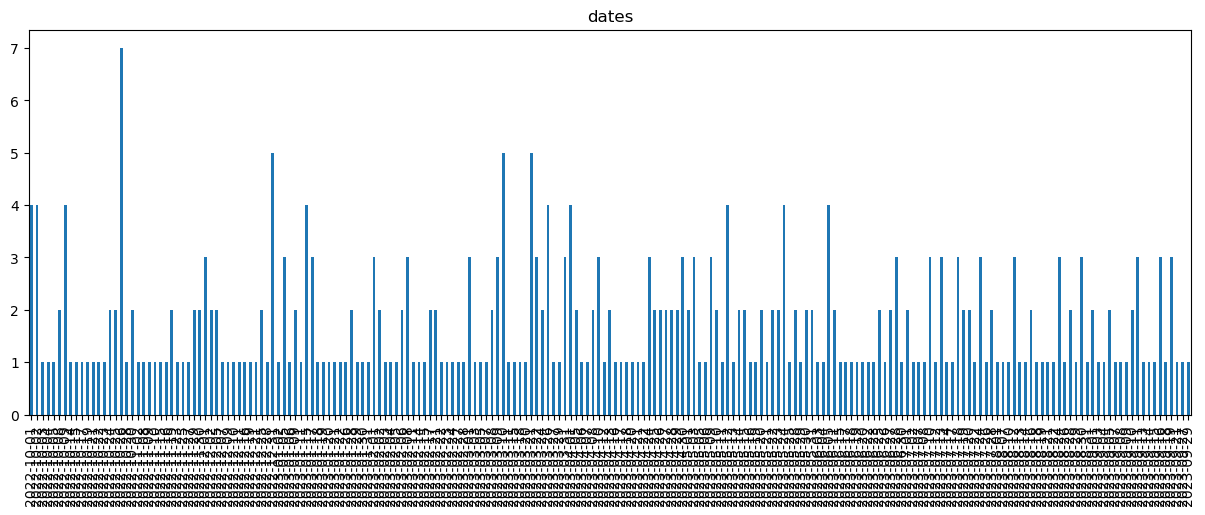

In [58]:
dates = [str(cat_select[ii].origins[0].time.date) for ii in range(len(cat_select))]

df = DataFrame()
df['dates'] = dates
df = df.sort_values(by="dates")

df2 = df.apply(value_counts)
df2.sort_index(inplace=True)

df2.dates.plot(kind='bar', subplots=True, figsize=(15, 5))

## Create Catalog of triggered events that were matched with catalog events

In [59]:
cat_select.write(config['path_to_catalogs']+config['output_filename'], format="QUAKEML")
print(f" -> storing: {config['path_to_catalogs']}{config['output_filename']} ... ")

 -> storing: /import/kilauea-data/BSPF/data/catalogs/BSPF_catalog_20221001_20230930_triggered.xml ... 


In [60]:
cata_df = __catalog_to_dataframe(cat_select)


## create a data frame for the triggered catalog
cata_df = cata_df.rename_axis('origin').reset_index()
cata_df['seconds'] = [abs(UTCDateTime(str(tt))-UTCDateTime("2022-10-01")) for tt in cata_df.origin]
cata_df['trigger_time'] = df_all.trigger_time
cata_df['arrival_time'] = df_all.arrival_time
cata_df['event_time'] = df_all.event_time
cata_df['cosum'] = df_all.coincidence_sum


## add information on epicentral distance and backazimuths
cata_df = __add_distances_and_backazimuth(config['BSPF_lat'], config['BSPF_lon'], cata_df)

## remove events where magnitude is smaller than 1 and distance is larger than 15km
cata_df.drop(cata_df[(cata_df.magnitude < 1) & (cata_df.distances_km > 15)].index, inplace=True)
cata_df.reset_index(drop=True)

## remove duplicated trigger times and event times
cata_df = cata_df.drop_duplicates("trigger_time", keep="first").reset_index(drop=True)
cata_df = cata_df.drop_duplicates("event_time").reset_index(drop=True)


## write data to output file
cata_df.to_pickle(config['path_to_catalogs']+config['output_filename'].replace(".xml",".pkl"))
print(f" -> storing: {config['path_to_catalogs']}{config['output_filename'].replace('.xml','.pkl')}...")

,origin,latitude,longitude,depth,magnitude,type,seconds,trigger_time,arrival_time,event_time,cosum,backazimuth,distances_km
0,2022-10-01 05:36:11.240,33.489667,-116.507167,9120.0,1.13,ml,20171.24,2022-10-01T05:36:10.344538Z,2022-10-01T05:36:11.240000Z,2022-10-01T05:36:11.240000Z,4.0,199.712618,14.252022
1,2022-10-01 05:36:11.240,33.489667,-116.507167,9120.0,1.13,ml,20171.24,2022-10-01T05:36:10.344539Z,2022-10-01T05:36:11.240000Z,2022-10-01T05:36:11.240000Z,5.0,199.712618,14.252022
2,2022-10-01 21:26:43.530,33.978000,-116.730500,15130.0,2.08,ml,77203.53,2022-10-01T21:26:51.694538Z,2022-10-01T21:26:43.530000Z,2022-10-01T21:26:43.530000Z,6.0,328.065144,48.053535
3,2022-10-01 21:26:43.530,33.978000,-116.730500,15130.0,2.08,ml,77203.53,2022-10-01T21:26:51.694539Z,2022-10-01T21:26:43.530000Z,2022-10-01T21:26:43.530000Z,5.0,328.065144,48.053535
4,2022-10-02 03:25:16.440,33.484333,-116.508500,8040.0,1.49,ml,98716.44,2022-10-02T03:25:19.269538Z,2022-10-02T03:25:16.440000Z,2022-10-02T03:25:16.440000Z,6.0,199.394033,14.850966
...,...,...,...,...,...,...,...,...,...,...,...,...,...
342,2023-09-19 16:59:23.750,33.640333,-116.725833,14080.0,1.58,ml,30560363.75,2023-09-19T16:59:28.415000Z,2023-09-19T16:59:23.750000Z,2023-09-19T16:59:23.750000Z,6.0,277.552483,25.304601
343,2023-09-19 18:17:24.190,33.464333,-116.567167,9220.0,1.45,ml,30565044.19,2023-09-19T18:17:27.765000Z,2023-09-19T18:17:24.190000Z,2023-09-19T18:17:24.190000Z,4.0,212.629455,19.262266
344,2023-09-21 01:58:24.210,33.545833,-116.455000,4870.0,0.68,ml,30679104.21,2023-09-21T01:58:25.900000Z,2023-09-21T01:58:24.210000Z,2023-09-21T01:58:24.210000Z,6.0,179.675029,7.188470
345,2023-09-27 13:41:07.510,33.496500,-116.556833,13430.0,1.18,ml,31239667.51,2023-09-27T13:41:10.990000Z,2023-09-27T13:41:07.510000Z,2023-09-27T13:41:07.510000Z,6.0,216.668239,15.777807


 -> storing: /import/kilauea-data/BSPF/data/catalogs/BSPF_catalog_20221001_20230930_triggered.pkl...


In [61]:
cata_df

,origin,latitude,longitude,depth,magnitude,type,seconds,trigger_time,arrival_time,event_time,cosum,backazimuth,distances_km
0,2022-10-01 05:36:11.240,33.489667,-116.507167,9120.0,1.13,ml,20171.24,2022-10-01T05:36:10.344538Z,2022-10-01T05:36:11.240000Z,2022-10-01T05:36:11.240000Z,4.0,199.712618,14.252022
1,2022-10-01 21:26:43.530,33.978000,-116.730500,15130.0,2.08,ml,77203.53,2022-10-01T21:26:51.694538Z,2022-10-01T21:26:43.530000Z,2022-10-01T21:26:43.530000Z,6.0,328.065144,48.053535
2,2022-10-02 03:25:16.440,33.484333,-116.508500,8040.0,1.49,ml,98716.44,2022-10-02T03:25:19.269538Z,2022-10-02T03:25:16.440000Z,2022-10-02T03:25:16.440000Z,6.0,199.394033,14.850966
3,2022-10-02 15:51:37.180,33.480167,-116.398000,8240.0,1.68,ml,143497.18,2022-10-02T15:51:37.444539Z,2022-10-02T15:51:37.180000Z,2022-10-02T15:51:37.180000Z,6.0,159.749086,15.423592
4,2022-10-02 21:52:54.280,33.485333,-116.509333,9650.0,0.99,ml,165174.28,2022-10-02T21:52:57.394539Z,2022-10-02T21:52:54.280000Z,2022-10-02T21:52:54.280000Z,6.0,199.820062,14.772415
...,...,...,...,...,...,...,...,...,...,...,...,...,...
323,2023-09-19 16:59:23.750,33.640333,-116.725833,14080.0,1.58,ml,30560363.75,2023-09-19T16:59:28.415000Z,2023-09-19T16:59:23.750000Z,2023-09-19T16:59:23.750000Z,6.0,277.552483,25.304601
324,2023-09-19 18:17:24.190,33.464333,-116.567167,9220.0,1.45,ml,30565044.19,2023-09-19T18:17:27.765000Z,2023-09-19T18:17:24.190000Z,2023-09-19T18:17:24.190000Z,4.0,212.629455,19.262266
325,2023-09-21 01:58:24.210,33.545833,-116.455000,4870.0,0.68,ml,30679104.21,2023-09-21T01:58:25.900000Z,2023-09-21T01:58:24.210000Z,2023-09-21T01:58:24.210000Z,6.0,179.675029,7.188470
326,2023-09-27 13:41:07.510,33.496500,-116.556833,13430.0,1.18,ml,31239667.51,2023-09-27T13:41:10.990000Z,2023-09-27T13:41:07.510000Z,2023-09-27T13:41:07.510000Z,6.0,216.668239,15.777807


In [62]:
print("number of events: ", len(cata_df.origin))
print("max. magnitude: ", max(cata_df.magnitude))
print("min. magnitude: ", min(cata_df.magnitude))

print("max. distance: ", round(max(cata_df.distances_km),2), "km")
print("min. distance: ", round(min(cata_df.distances_km),2), "km")

number of events:  328
max. magnitude:  4.15
min. magnitude:  0.56
max. distance:  67.95 km
min. distance:  7.19 km


## Check for small magnitudes (if distances are reasonable)

In [63]:
cata_df

,origin,latitude,longitude,depth,magnitude,type,seconds,trigger_time,arrival_time,event_time,cosum,backazimuth,distances_km
0,2022-10-01 05:36:11.240,33.489667,-116.507167,9120.0,1.13,ml,20171.24,2022-10-01T05:36:10.344538Z,2022-10-01T05:36:11.240000Z,2022-10-01T05:36:11.240000Z,4.0,199.712618,14.252022
1,2022-10-01 21:26:43.530,33.978000,-116.730500,15130.0,2.08,ml,77203.53,2022-10-01T21:26:51.694538Z,2022-10-01T21:26:43.530000Z,2022-10-01T21:26:43.530000Z,6.0,328.065144,48.053535
2,2022-10-02 03:25:16.440,33.484333,-116.508500,8040.0,1.49,ml,98716.44,2022-10-02T03:25:19.269538Z,2022-10-02T03:25:16.440000Z,2022-10-02T03:25:16.440000Z,6.0,199.394033,14.850966
3,2022-10-02 15:51:37.180,33.480167,-116.398000,8240.0,1.68,ml,143497.18,2022-10-02T15:51:37.444539Z,2022-10-02T15:51:37.180000Z,2022-10-02T15:51:37.180000Z,6.0,159.749086,15.423592
4,2022-10-02 21:52:54.280,33.485333,-116.509333,9650.0,0.99,ml,165174.28,2022-10-02T21:52:57.394539Z,2022-10-02T21:52:54.280000Z,2022-10-02T21:52:54.280000Z,6.0,199.820062,14.772415
...,...,...,...,...,...,...,...,...,...,...,...,...,...
323,2023-09-19 16:59:23.750,33.640333,-116.725833,14080.0,1.58,ml,30560363.75,2023-09-19T16:59:28.415000Z,2023-09-19T16:59:23.750000Z,2023-09-19T16:59:23.750000Z,6.0,277.552483,25.304601
324,2023-09-19 18:17:24.190,33.464333,-116.567167,9220.0,1.45,ml,30565044.19,2023-09-19T18:17:27.765000Z,2023-09-19T18:17:24.190000Z,2023-09-19T18:17:24.190000Z,4.0,212.629455,19.262266
325,2023-09-21 01:58:24.210,33.545833,-116.455000,4870.0,0.68,ml,30679104.21,2023-09-21T01:58:25.900000Z,2023-09-21T01:58:24.210000Z,2023-09-21T01:58:24.210000Z,6.0,179.675029,7.188470
326,2023-09-27 13:41:07.510,33.496500,-116.556833,13430.0,1.18,ml,31239667.51,2023-09-27T13:41:10.990000Z,2023-09-27T13:41:07.510000Z,2023-09-27T13:41:07.510000Z,6.0,216.668239,15.777807


In [64]:
print(len(cata_df[cata_df.magnitude < 1]), cata_df.magnitude.min())
cata_df[cata_df.magnitude < 1]


29 0.56


,origin,latitude,longitude,depth,magnitude,type,seconds,trigger_time,arrival_time,event_time,cosum,backazimuth,distances_km
4,2022-10-02 21:52:54.280,33.485333,-116.509333,9650.0,0.99,ml,165174.28,2022-10-02T21:52:57.394539Z,2022-10-02T21:52:54.280000Z,2022-10-02T21:52:54.280000Z,6.0,199.820062,14.772415
10,2022-10-09 08:33:00.550,33.553500,-116.406167,8330.0,0.91,ml,721980.55,2022-10-09T08:33:01.044538Z,2022-10-09T08:33:00.550000Z,2022-10-09T08:33:00.550000Z,4.0,144.168138,7.816232
12,2022-10-09 17:51:16.290,33.488000,-116.501833,10350.0,0.88,ml,755476.29,2022-10-09T17:51:19.569538Z,2022-10-09T17:51:16.290000Z,2022-10-09T17:51:16.290000Z,6.0,197.588132,14.268919
17,2022-10-21 08:53:10.210,33.513500,-116.502667,13120.0,0.87,ml,1759990.21,2022-10-21T08:53:13.194538Z,2022-10-21T08:53:10.210000Z,2022-10-21T08:53:10.210000Z,6.0,202.159994,11.632836
37,2022-11-15 16:02:41.970,33.573167,-116.595667,13450.0,0.87,ml,3945761.97,2022-11-15T16:02:45.244538Z,2022-11-15T16:02:41.970000Z,2022-11-15T16:02:41.970000Z,6.0,252.328490,13.664113
47,2022-12-01 20:26:07.810,33.499500,-116.503500,10260.0,0.81,ml,5343967.81,2022-12-01T20:26:01.469539Z,2022-12-01T20:26:07.810000Z,2022-12-01T20:26:07.810000Z,6.0,199.916079,13.110421
91,2023-01-29 18:12:03.480,33.550167,-116.406667,6420.0,0.82,ml,10433523.48,2023-01-29T18:12:05.319538Z,2023-01-29T18:12:03.480000Z,2023-01-29T18:12:03.480000Z,6.0,145.966327,8.092893
96,2023-02-02 05:54:33.150,33.488333,-116.469833,13560.0,0.68,ml,10734873.15,2023-02-02T05:54:36.469538Z,2023-02-02T05:54:33.150000Z,2023-02-02T05:54:33.150000Z,4.0,185.631780,13.631597
99,2023-02-04 19:49:37.680,33.522333,-116.524000,11810.0,0.95,ml,10957777.68,2023-02-04T19:49:40.544538Z,2023-02-04T19:49:37.680000Z,2023-02-04T19:49:37.680000Z,5.0,213.040138,11.681804
103,2023-02-08 17:14:33.500,33.508833,-116.454500,6190.0,0.91,ml,11294073.50,2023-02-08T17:14:29.769538Z,2023-02-08T17:14:33.500000Z,2023-02-08T17:14:33.500000Z,4.0,179.557331,11.292504


## Check for duplicated events

In [65]:
cata_df[cata_df.duplicated("event_time", keep=False)]
cata_df[cata_df.duplicated("trigger_time", keep=False)]

,origin,latitude,longitude,depth,magnitude,type,seconds,trigger_time,arrival_time,event_time,cosum,backazimuth,distances_km


,origin,latitude,longitude,depth,magnitude,type,seconds,trigger_time,arrival_time,event_time,cosum,backazimuth,distances_km


In [66]:
## remove clearly visible outlier on 2023-04-30T07:26:56.390000Z
# cata_df[(cata_df.seconds > 86400*210) & (cata_df.seconds < 86400*215)]

# print(cat.filter("time > 2023-04-30T06:10","time < 2023-04-30T08:20", "magnitude > 2", inverse=False).__str__(print_all=True))

In [67]:
cata_df[cata_df.magnitude > 3]

,origin,latitude,longitude,depth,magnitude,type,seconds,trigger_time,arrival_time,event_time,cosum,backazimuth,distances_km
5,2022-10-03 16:08:09.970,33.924667,-116.921500,7620.0,3.01,ml,230889.97,2022-10-03T16:08:19.219538Z,2022-10-03T16:08:09.970000Z,2022-10-03T16:08:09.970000Z,5.0,309.024563,55.472148
19,2022-10-23 09:24:58.150,33.480667,-116.426167,5790.0,3.27,ml,1934698.15,2022-10-23T09:24:58.944538Z,2022-10-23T09:24:58.150000Z,2022-10-23T09:24:58.150000Z,5.0,169.312421,14.670320
63,2022-12-31 12:12:26.650,33.397500,-116.393333,3880.0,4.14,mw,7906346.65,2022-12-31T12:12:27.253800Z,2022-12-31T12:12:26.650000Z,2022-12-31T12:12:26.650000Z,6.0,166.264929,24.334570
74,2023-01-09 19:42:56.460,33.396000,-116.396667,4890.0,3.18,ml,8710976.46,2023-01-09T19:43:00.019538Z,2023-01-09T19:42:56.460000Z,2023-01-09T19:42:56.460000Z,5.0,167.064154,24.425123
75,2023-01-11 18:59:20.030,33.699833,-116.761333,15820.0,3.23,ml,8881160.03,2023-01-11T18:59:25.219538Z,2023-01-11T18:59:20.030000Z,2023-01-11T18:59:20.030000Z,4.0,289.306150,30.048739
94,2023-02-01 09:05:02.320,33.886000,-116.257833,3190.0,3.11,ml,10659902.32,2023-02-01T09:05:08.169538Z,2023-02-01T09:05:02.320000Z,2023-02-01T09:05:02.320000Z,6.0,30.887144,35.609655
146,2023-03-24 13:45:13.700,33.178000,-116.409500,11690.0,3.42,ml,15083113.70,2023-03-24T13:45:21.144538Z,2023-03-24T13:45:13.700000Z,2023-03-24T13:45:13.700000Z,4.0,174.897540,48.175041
155,2023-04-01 01:16:07.810,33.381667,-116.909667,12960.0,4.15,mw,15729367.81,2023-04-01T01:16:10.369538Z,2023-04-01T01:16:07.810000Z,2023-04-01T01:16:07.810000Z,4.0,239.091314,49.261011
181,2023-04-26 06:46:58.450,34.028833,-116.845667,19700.0,3.56,mlr,17909218.45,2023-04-26T06:47:07.485000Z,2023-04-26T06:46:58.450000Z,2023-04-26T06:46:58.450000Z,5.0,322.195281,58.794108
211,2023-05-20 08:18:16.240,33.382167,-116.906667,12640.0,3.38,ml,19988296.24,2023-05-20T08:18:24.570000Z,2023-05-20T08:18:16.240000Z,2023-05-20T08:18:16.240000Z,6.0,238.977903,48.993538


## Select good events manually

In [8]:
good_event = [
            "20221002_032516",
            "20221015_051734",
            "20221023_092458",
            "20221026_081433", ## double event
            "20221231_121226",
            "20230109_194256",
            "20230301_224903",
            "20230308_040732",
            "20230410_145054",
            "20230417_185236",
            "20230425_115547",
            "20230430_221115",
            "20230707_160229",
            "20230828_102734",
            "20230830_153205",
            "20230911_092015",
            "20230919_003513"
           ]

In [99]:
## get indices of good events
idx = []
for ge in good_event:
    for i, ev in zip(cata_df.index, cata_df.origin):
        ev_str = str(ev).split(".")[0].replace(" ", "_").replace("-","").replace(":","")
        if ge == ev_str:
            idx.append(i)

## extract good events as separate catalog
cata_good = cata_df[cata_df.index.isin(idx)].reset_index().rename(columns={"index":"event_number"})

## write data to output file
cata_good.to_pickle(config['path_to_catalogs']+f"good_events_{config['time_period']}.pkl")
print(f" -> storing: {config['path_to_catalogs']}good_events_{config['time_period']}.pkl ...")

 -> storing: /import/kilauea-data/BSPF/data/catalogs/good_events_20221001_20230930.pkl ...
